# Esonero 2 - 17 Maggio 2021

#### GAETANO PALMIERI 216701

Completare i seguenti esercizi tramite uno o più blocchi di codice descrivendo le operazioni effettuate


In [8]:
# import
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import image as mp_image
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from scipy.ndimage import convolve, correlate, filters
from scipy import misc, ndimage
import numpy.linalg as LA
import torch

import torch.nn as nn
from torch.nn import functional as F


# Esercizio 1

Data la seguente immagine, costruire la feature pyramid di gaussiane e descrivere il procedimento

![](figure1.jpg)

Shape (1200, 1920)


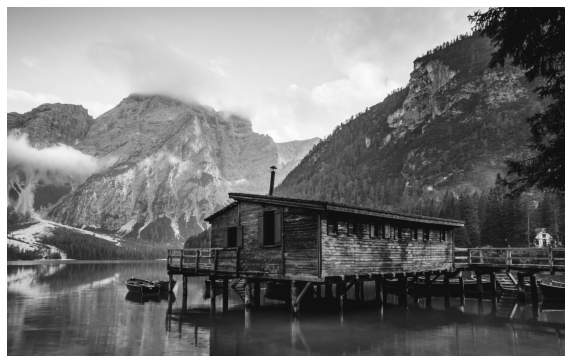

In [2]:
## Lettura img + conversione in scala di grigi

def img_show(image, **argv):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, **argv)  # display the image
    plt.axis('off')
    plt.show()

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

    
image = mp_image.imread(os.path.join('figure1.jpg'))
image = rgb2gray(image)
maxv, minv = np.max(image), np.min(image)
image = (image - minv)/(maxv-minv)
print('Shape', image.shape)
img_show(image,cmap=cm.gray)

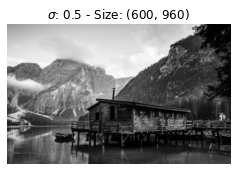

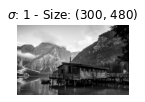

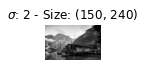

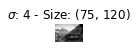

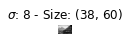

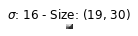

In [3]:
## Costruzione della piramide 
# Parto dall img iniziale, applico il filtro sempre con la stessa scala e poi vado a dimezzare
sz = 4
num_octave = 6 # Numero di ottave
cur_scale = np.copy(image)
sigma = 1 # Scala costante

for i in range(num_octave):
    cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
    cur_scale = cur_scale[::2,::2]  # Dimezzo
    
    plt.figure(figsize=(sz, sz))
    plt.imshow(cur_scale,cmap=cm.gray)
    s = 2*np.ceil(3*2**(i-1))+1
    plt.title(f'$\sigma$: {2**(i-1)} - Size: {cur_scale.shape}')
    plt.axis('off')
    plt.show()
    
    sz = sz/2
    
#Posso fare questo tipo di trasformazione grazie alle proprietà sostanziali del filtro gaussiano per cui applicandolo 
#ripetutamente è come se si stessero sommando ripetutamente le varie operazioni di scala. 

#Si può notare che, man mano che si scende sulla scala,si perdono alcuni dettagli e 
#quindi il focus può passare via via su diversi dettagli specifici.

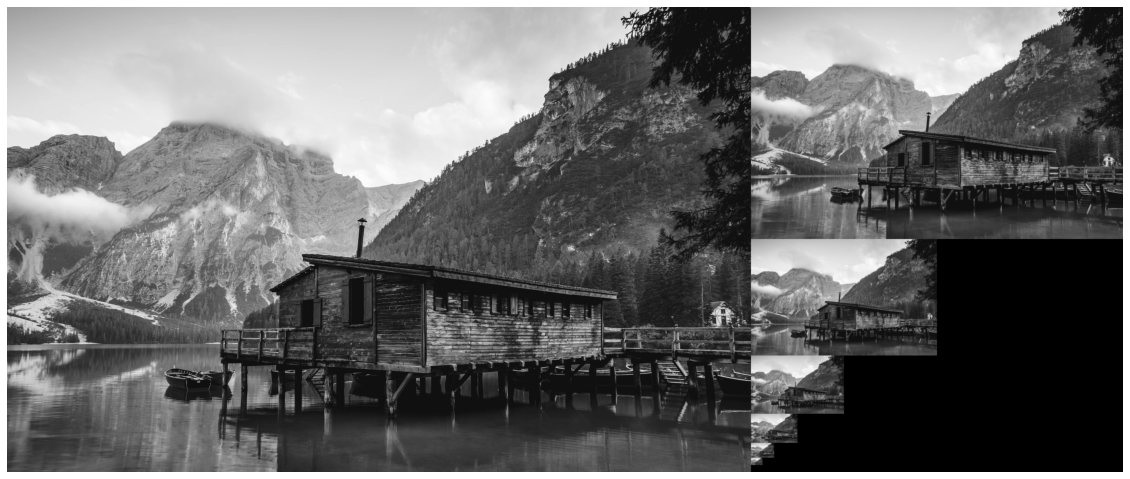

In [4]:
## Rappresentazione Compatta:
rows,cols = image.shape
output = np.zeros((rows,cols+cols//2))
output[:rows,:cols] = image
num_octave = 6
sigma = 1
cur_scale = image
horiz = True
rows = 0
for i in range(num_octave):
    cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
    cur_scale = cur_scale[::2,::2]
    rows_scaled, cols_scaled = cur_scale.shape
    output[rows:rows+rows_scaled,cols:cols+cols_scaled] = cur_scale
    rows += rows_scaled
        
        
plt.figure(figsize=(20, 20))

plt.imshow(output,cmap=cm.gray)
plt.axis('off')
plt.show()

# Esercizio 2


Data la seguente sequenza di tensori e la funzione *f*, calcolare il gradiente per i tensori a,b,c,d,e,y. 

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita. 

$
y = f(a,b,c,d,e) = \sum \frac {a^5 + \exp(b^2) * d * \sin (c)} {3e + 1}
$

*non sono necessarie librerie esterne*

In [46]:
a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)

r1= torch.pow(a,5)
r1.retain_grad() # Calcolo della derivata parziale
r2 = torch.pow(b,2)
r2.retain_grad()
r22 = torch.exp(r2)
r22.retain_grad()
r3 = torch.sin(c)
r4= r22*d*r3
r4.retain_grad()
numeratore= r4 + r1
numeratore.retain_grad()
d1= 3 * e 
d1.retain_grad()
d2= d1 + 1
d2.retain_grad()
tot= numeratore / d2
tot.retain_grad()


y= torch.sum(tot)
print(y)
y.backward()

tensor(-2.4471e+15, grad_fn=<SumBackward0>)


# Esercizio 3

Dati due batch A e B, mostrare gli effetti della BN.

Suggerimento: calcolare gli istogrammi di A e B

# Esercizio 4

Dato il seguente frammento di codice

In [21]:
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

model = lambda x: conv2(conv1(x))

x = torch.rand(1,3,400,400)
output=model(x)
output.shape

torch.Size([1, 30, 66, 50])

Quello che accade qui è il calcolo di 2 convoluzioni successive. 
Conv1 riceve in input una img a 3 canali (in_channel = 3) e ritorna una feature map a 10 canali,applicando un kernel 3 x 3.
Conv2 va ad operare, con valori diversi, in modo analogo.

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio. 

# Esercizio 5

Adattare/semplificare la rete AlexNet affinché gestisca un input di immagini 400x400

In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test(net,img_size=32):
    x = torch.randn(1,3,img_size,img_size)
    y = net(x)
    print("Input: {}; Output: {}; N. of params: {:,}".format(list(x.size()), list(y.size()), count_parameters(net)))

In [41]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), 
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [67]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        
        print(x.size())
        x = x.view(-1, 6*6*256)
        x = self.layer8(self.layer7(self.layer6(x)))
        
        return x

In [ ]:
net = AlexNet()

test(net,400)

Siccome una convoluzione è un'operazione translation-invariant, cioè dipende da dove viene applicata sull'immagine, si può ridimensionare l input 

# Esercizio 6

Data la seguente immagine, costruire due Bounding box con IoU = 0.5. 
Descrivere tutte le operazioni effettuate

![](figure2.jpg)

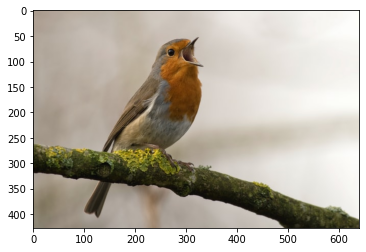

In [60]:
import cv2
import numpy
import matplotlib.pyplot as plt
img = cv2.imread('figure2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

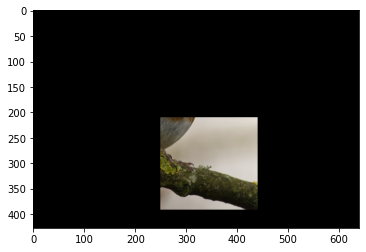

In [61]:
first_bb_points = [[250, 210], [440, 210], [440, 390], [250, 390]]
stencil = numpy.zeros(img.shape).astype(img.dtype)
contours = [numpy.array(first_bb_points)]
color = [255, 255, 255]
cv2.fillPoly(stencil, contours, color)
result1 = cv2.bitwise_and(img, stencil)
result1 = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)
plt.imshow(result1)

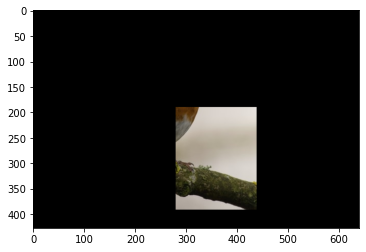

In [62]:
second_bb_points = [[280, 190], [438, 190], [438, 390], [280, 390]]
stencil = numpy.zeros(img.shape).astype(img.dtype)
contours = [numpy.array(second_bb_points)]
color = [255, 255, 255]
cv2.fillPoly(stencil, contours, color)
result2 = cv2.bitwise_and(img, stencil)
result2 = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)
plt.imshow(result2)

In [64]:
# IoU calculation
intersection = numpy.logical_and(result1, result2)
union = numpy.logical_or(result1, result2)
iou_score = numpy.sum(intersection) / numpy.sum(union)
print(iou_score)

0.762869369926966
